In [7]:
import json
import os
from pathlib import Path

# Define paths
batch_query_jsonl_file = "/mnt/fast10/brandon/mmr_rollout_data/raw_rollouts/soft_estimation/AI2D/verification/verification_pipeline_outputs/o4-mini/AI2D/verification_batches/batch_0001.jsonl"
batch_verification_result_json_file = "/mnt/fast10/brandon/mmr_rollout_data/raw_rollouts/soft_estimation/AI2D/verification/verification_pipeline_outputs/o4-mini/AI2D/batch_0001_verification_results.json"
output_dir = "/mnt/fast10/brandon/mmr_rollout_data/merged_verification_files"

# Extract dataset name from path
dataset_name = batch_query_jsonl_file.split('/')[-3]  # Gets "AI2D" from batch_0001.jsonl

# print(dataset_name)
# # Create output directory
Path(output_dir).mkdir(parents=True, exist_ok=True)

# # Load JSONL file into dict
batch_query_data = {}
with open(batch_query_jsonl_file, 'r') as f:
    for line in f:
        item = json.loads(line)
        batch_query_data[item['custom_id']] = item

# print(len(batch_query_data.keys()))

In [ ]:
# # Load JSON file
with open(batch_verification_result_json_file, 'r') as f:
    batch_verification_data = json.load(f)

# Check all custom_ids and custom_ids match
json_ids = {item['custom_id'] for item in batch_verification_data}
jsonl_ids = set(batch_query_data.keys())

if jsonl_ids != json_ids:
    missing_in_json = jsonl_ids - json_ids
    missing_in_jsonl = json_ids - jsonl_ids
    if missing_in_json:
        print(f"custom_ids in JSONL not found in JSON: {missing_in_json}")
    if missing_in_jsonl:
        print(f"custom_ids in JSON not found in JSONL: {missing_in_jsonl}")
else:
    print(f"All custom_ids and custom_ids match")

# Merge and save
output_path = os.path.join(output_dir, f"{dataset_name}_verification_merged.jsonl")
with open(output_path, 'w') as f:
    for item in batch_verification_data:
        merged = {**batch_query_data[item['custom_id']], **item}
        f.write(json.dumps(merged) + '\n')

print(f"Merged {len(batch_verification_data)} items to {output_path}")

All custom_ids and custom_ids match
Merged 746 items to /mnt/fast10/brandon/mmr_rollout_data/merged_verification_files/AI2D_verification_merged.jsonl


First line of merged file:
{
  "custom_id": "d8086fbb-f598-450c-8e53-15074142e4ab",
  "method": "POST",
  "url": "/chat/completions",
  "body": {
    "model": "o4-mini",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "I will provide a visual reasoning problem along with a solution. They will be formatted as follows, where m and n need not be equal: \n\n```\n[Visual Reasoning Problem]\n\n <visual_reasoning_problem>\n ...(visual reasoning problem)... \n</visual_reasoning_problem> \n\n[Solution]\n\n<solution>\n[Visual Elements]\n<step_1>\n...(Step 1 of step-by-step visual elements perception)...\n</step_1>\n<step_2>\n...(Step 2 of step-by-step visual elements perception)...\n</step_2>\n...\n<step_m>\n...(Step m of step-by-step visual elements perception)...\n</step_m>\n\n[Reasoning]\n<step_1>\n...(Step 1 of step-by-step reasoning)...\n</step_1>\n<step_2>\n...(Step 2 of step-by-step reasoning)...\n</step_2>
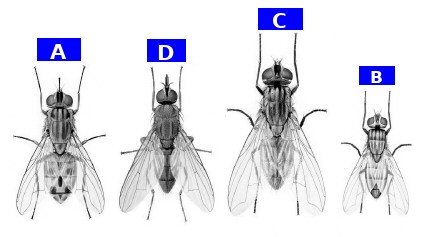

In [ ]:
# Print first line of merged file
with open(output_path, 'r') as f:
    first_line = f.readline().strip()
    if first_line:
        first_item = json.loads(first_line)
        print("First line of merged file:")
        print(json.dumps(first_item, indent=2))
    else:
        print("File is empty")

In [ ]:
import re

# Extract solutions from merged file
solutions = []
solution_pattern = re.compile(r'<solution>(.*?)</solution>', re.DOTALL)

with open(output_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        item = json.loads(line)
        try:
            text = item["body"]["messages"][0]["content"][0]["text"]
            match = solution_pattern.search(text)
            if match:
                solution_text = match.group(1).strip()
                if solution_text:  # Only add non-empty solutions
                    solutions.append({
                        "uid": item.get("UID", item.get("custom_id")),
                        "unique_key": solution_text
                    })
            else:
                print(f"Warning: No <solution> tags found in line {line_num}")
        except (KeyError, IndexError, TypeError) as e:
            print(f"Error accessing text in line {line_num}: {e}")

print(f"Extracted {len(solutions)} valid solutions")

In [ ]:
# Load flattened file once into memory
flattened_path = "/mnt/fast10/brandon/mmr_rollout_data/flattened_rollout_files/AI2D_flattened.jsonl"
flattened_data = []

with open(flattened_path, 'r') as f:
    for line in f:
        item = json.loads(line)
        flattened_data.append({
            "response": item.get("response", ""),
            "uid": item.get("uid")
        })

print(f"Loaded {len(flattened_data)} items from flattened file")

# Check each solution for matches
collision_errors = []

for sol in solutions:
    unique_key = sol["unique_key"]
    
    # Find all matches
    matches = [item for item in flattened_data if item["response"] == unique_key]
    
    if len(matches) > 1:
        collision_errors.append({
            "unique_key": unique_key,
            "verification_uid": sol["uid"],
            "matches": matches
        })
    elif len(matches) == 0:
        print(f"No match found for UID: {sol['uid']}")

# Report collision errors
if collision_errors:
    print(f"\n🚨 COLLISION ERRORS FOUND: {len(collision_errors)} unique_keys have multiple matches!")
    for error in collision_errors:
        print(f"\nCollision for verification UID: {error['verification_uid']}")
        print(f"Unique_key: {error['unique_key'][:100]}...")
        print(f"Found {len(error['matches'])} matches:")
        for match in error['matches']:
            print(f"  - uid: {match['uid']}, response: {match['response'][:50]}...")
    
    raise ValueError(f"{len(collision_errors)} collision errors found. See details above.")
else:
    print(f"\n✅ No collisions found! All {len(solutions)} solutions have at most one match.")